# MLFlow Lab - Disaster Tweet Prediction

This lab aims to use a labeled dataset of tweets and trains a model to predict whether or not the they describe a natural disaster. MLFlow is used to track model performance, register trained models, and perform real-time inference.

## 1. Load and Analyze Data

In [1]:
import pandas as pd

df = pd.read_csv('./data/tweets.csv')
df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


For this lab, we'll only use the tweet text for prediction:

In [2]:
df = df.drop(['id', 'keyword', 'location'], axis=1)
df.head()

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0


## 2. Exploratory Data Analysis

All tweets in this dataset have a 140 character limit. How are our labels distributed?

Class counts:
Non-disaster: 9256
Disaster: 2114


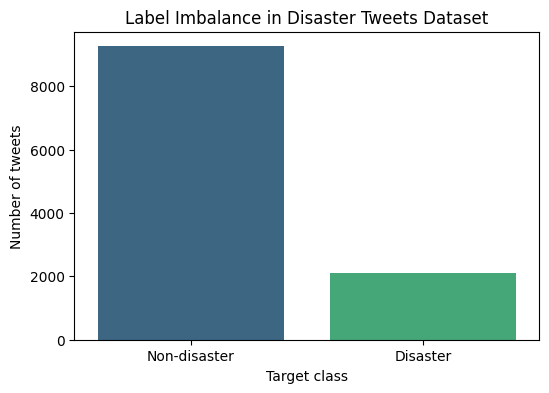

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Print the counts
class_counts = df['target'].value_counts()
print("Class counts:")
for cls, count in class_counts.items():
    label = "Disaster" if cls == 1 else "Non-disaster"
    print(f"{label}: {count}")

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks([0,1], ['Non-disaster', 'Disaster'])
plt.ylabel("Number of tweets")
plt.xlabel("Target class")
plt.title("Label Imbalance in Disaster Tweets Dataset")
plt.show()


## 2. Preprocessing

In [ ]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)         # remove URLs
    text = re.sub(r"@\w+", "", text)            # remove @mentions
    text = re.sub(r"#", "", text)               # remove hashtag symbol but keep the word
    text = re.sub(r"[^a-z\s]", "", text)        # remove non-alphabetic characters
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text

df["clean_text"] = df["text"].apply(clean_text)

# Data splitting
X_train, X_temp, y_train, y_temp = train_test_split(
    df["clean_text"], df["target"], test_size=0.3, random_state=42, stratify=df["target"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),        # include unigrams and bigrams
    stop_words="english"
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print("✅ Preprocessing complete:")
print(f"Train shape: {X_train_vec.shape}")
print(f"Validation shape: {X_val_vec.shape}")
print(f"Test shape: {X_test_vec.shape}")

✅ Preprocessing complete:
Train shape: (7959, 5000)
Validation shape: (1705, 5000)
Test shape: (1706, 5000)


## 3. Baseline Model

In [ ]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import pandas as pd
import os
import joblib

# Model wrapper
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer

    def predict(self, context, model_input):
        if isinstance(model_input, pd.DataFrame) and "text" in model_input.columns:
            X_vec = self.vectorizer.transform(model_input["text"])
        else:
            X_vec = model_input
        return self.model.predict_proba(X_vec)[:, 1]

# ---- MLflow run ----
with mlflow.start_run(run_name="baseline_rf_disaster_tweets_with_vectorizer") as run:
    run_id = run.info.run_id

    n_estimators = 100
    random_state = 42

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight='balanced', n_jobs=-1)
    model.fit(X_train_vec, y_train)

    val_preds = model.predict_proba(X_val_vec)[:, 1]
    test_preds = model.predict_proba(X_test_vec)[:, 1]

    val_auc = roc_auc_score(y_val, val_preds)
    test_auc = roc_auc_score(y_test, test_preds)

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_metric("val_auc", val_auc)
    mlflow.log_metric("test_auc", test_auc)

    os.makedirs("artifacts", exist_ok=True)
    vectorizer_path = "artifacts/tfidf_vectorizer.pkl"
    joblib.dump(vectorizer, vectorizer_path)

    # Log the vectorizer as an artifact
    mlflow.log_artifact(vectorizer_path, artifact_path="preprocessing")

    # Wrap model for MLflow
    wrapped_model = SklearnModelWrapper(model, vectorizer)

    # Example input for signature
    example_input = pd.DataFrame({"text": ["Major flooding in Jakarta city center"]})
    signature = infer_signature(example_input, wrapped_model.predict(None, example_input))

    # Log the full wrapped model
    artifact_path = "rf_text_model"
    mlflow.pyfunc.log_model(
        artifact_path=artifact_path,
        python_model=wrapped_model,
        signature=signature,
    )

    print(f"Run complete — Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}")
    print(f"Run ID: {run_id}")



Run complete — Val AUC: 0.9110, Test AUC: 0.8845
Run ID: 1ca6ef9d784e412eb1873486056513d7


## 4. Model Registration

In [6]:
import time

model_name = "disaster_tweets_rf"
model_version = mlflow.register_model(
    model_uri=f"runs:/{run_id}/{artifact_path}",
    name=model_name
)
time.sleep(15)

Registered model 'disaster_tweets_rf' already exists. Creating a new version of this model...
Created version '5' of model 'disaster_tweets_rf'.


## 5. Transition to Production

In [7]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production"
)

print(f"Model '{model_name}' version {model_version.version} transitioned to Production")

Model 'disaster_tweets_rf' version 5 transitioned to Production


## 6. Inference

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

prod_model = mlflow.pyfunc.load_model(f"models:/{model_name}/Production")
X_test_input = pd.DataFrame({"text": X_test})  # X_test = raw tweet text

# Perform batch inference to get predicted probabilities
pred_probs = prod_model.predict(X_test_input)

auc = roc_auc_score(y_test, pred_probs)
pred_labels = (pred_probs >= 0.5).astype(int)
accuracy = accuracy_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"Batch Inference Complete:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


Batch Inference Complete:
AUC: 0.8845
Accuracy: 0.8834
F1 Score: 0.6012


## 7. Serve Model for Real-Time Inference

This code starts the MLflow model server in the background, sends the test tweet data to the deployed model, computes evaluation metrics such as AUC, accuracy, and F1 score, and then shuts down the server automatically. It emulates a production-style workflow directly within the notebook.

In [9]:
import subprocess
import time
import requests
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

model_name = "disaster_tweets_rf"
server_port = 5001
max_retries = 20
retry_delay = 2

# Start server in background
server_process = subprocess.Popen([
    "mlflow", "models", "serve",
    "-m", f"models:/{model_name}/Production",
    "-p", str(server_port),
    "--no-conda"
], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

url = f"http://localhost:{server_port}/invocations"
for i in range(max_retries):
    try:
        requests.get(url)
        print(f"MLflow server is up (attempt {i+1})")
        break
    except requests.exceptions.ConnectionError:
        time.sleep(retry_delay)
else:
    server_process.terminate()
    raise RuntimeError("MLflow server failed to start after retries.")


MLflow server is up (attempt 2)


In [10]:
# Test and evaluate

X_test_input = pd.DataFrame({"text": X_test})
data_dict = {"dataframe_split": X_test_input.to_dict(orient='split')}

response = requests.post(url, json=data_dict)
response_json = response.json()

pred_probs = np.array(response_json["predictions"], dtype=float)
pred_labels = (pred_probs >= 0.5).astype(int)

auc = roc_auc_score(y_test, pred_probs)
accuracy = accuracy_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"\nBatch Inference Complete:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


Batch Inference Complete:
AUC: 0.8845
Accuracy: 0.8834
F1 Score: 0.6012


In [11]:
# Stop server

server_process.terminate()
server_process.wait()
print("MLflow server stopped.")

MLflow server stopped.
